<a href="https://colab.research.google.com/github/pradrattana/anime_commission_suggested_price/blob/main/anime_price_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
!pip install -Uqq fastbook
!pip install -Uqq fastai

     |████████████████████████████████| 727kB 13.3MB/s 
     |████████████████████████████████| 1.2MB 30.3MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 194kB 54.6MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/img.zip" -d "/content/"

In [4]:
from fastbook import *
from fastai.tabular.all import *
from fastai.vision.widgets import *
from sklearn.metrics import mean_absolute_error
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [9]:
path_img = Path('/content/img/')
path_csv = Path('/content/anime.csv')
os.rename("/content/img/test", "/content/test/")
df = pd.read_csv(path_csv)
df

,path,day,price,size,color,bg,like,completed,dataset
0,img-0.jpeg,7,10.0,3,1,0,3,10,train
1,img-2.jpg,3,5.0,1,1,0,28,45,train
2,img-3.jpg,2,5.0,3,1,0,6,11,train
3,img-4.jpg,5,5.0,3,1,0,10,11,train
4,img-5.jpg,7,5.0,1,1,0,14,42,test
...,...,...,...,...,...,...,...,...,...
2023,img-10566.jpg,7,90.0,4,1,0,19,27,valid
2024,img-10569.jpg,5,90.0,3,1,0,0,5,valid
2025,img-10581.png,10,90.0,3,1,0,1,17,train
2026,img-10591.jpg,9,90.0,4,0,0,0,17,test


# Image Regression


In [ ]:
def img_price(o):
    for i, row in df.iterrows():
        if row.path==os.path.basename(o): return row.price

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock), 
    get_items=get_image_files, 
    splitter=FuncSplitter(lambda o: Path(o).parent.name=='valid'), 
    get_y=img_price, 
    item_tfms=Resize(400, method=ResizeMethod.Squish), 
    batch_tfms=aug_transforms(size=400, pad_mode=PadMode.Reflection , flip_vert=False),  
)

In [ ]:
dls_img = dblock.dataloaders(path_img, bs=32)

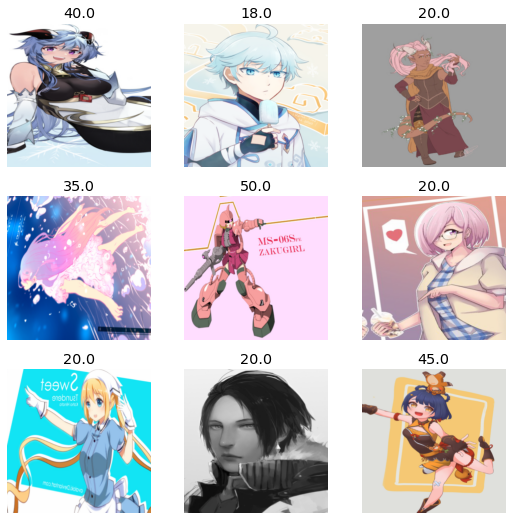

In [ ]:
dls_img.train.show_batch(max_n=9, nrows=3)

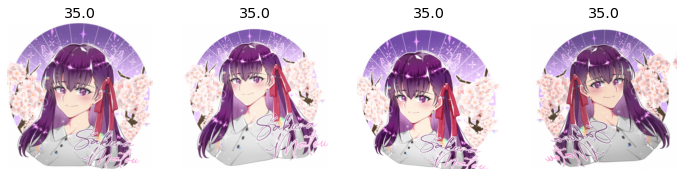

In [ ]:
dls_img.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
learn_img = cnn_learner(dls_img, 
                    densenet121, 
                    metrics=[mae, mse, rmse])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


SuggestedLRs(valley=tensor(0.0398))

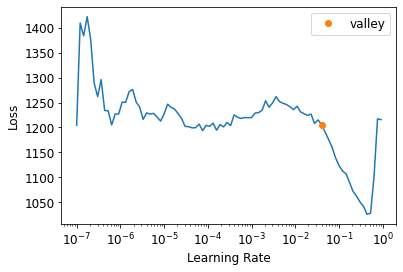

In [ ]:
learn_img.lr_find()

In [ ]:
learn_img.fine_tune(epochs=10, base_lr=1e-2)

epoch,train_loss,valid_loss,mae,mse,_rmse,time
0,977.002502,559.061829,18.321875,559.061829,23.644487,01:13


epoch,train_loss,valid_loss,mae,mse,_rmse,time
0,398.873993,307.407349,13.046007,307.407349,17.533035,01:15
1,254.015808,314.430725,13.452680,314.430725,17.732195,01:16
2,236.242493,634.263855,20.233114,634.263855,25.184595,01:16
3,195.264053,260.444977,12.379437,260.444977,16.138308,01:16
4,162.772034,252.905228,12.246112,252.905228,15.902994,01:15
5,128.574997,213.352036,11.381666,213.352036,14.606575,01:16
6,104.929504,237.755737,11.572107,237.755737,15.419330,01:16
7,77.176834,228.075653,11.382757,228.075653,15.102175,01:16
8,65.188255,216.859207,11.218505,216.859207,14.726140,01:15
9,56.274235,216.462296,11.112080,216.462296,14.712658,01:15


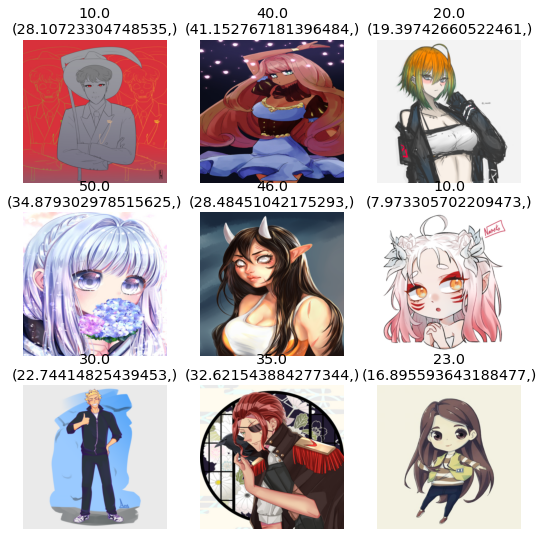

In [ ]:
learn_img.show_results()

# Tabular Regression

In [ ]:
df_train = df.drop(df[df.dataset=='test'].index)
df_train

,path,day,price,size,color,bg,like,completed,dataset
0,img-0.jpeg,7,10.0,3,1,0,3,10,train
1,img-2.jpg,3,5.0,1,1,0,28,45,train
2,img-3.jpg,2,5.0,3,1,0,6,11,train
3,img-4.jpg,5,5.0,3,1,0,10,11,train
5,img-6.png,6,5.0,4,1,0,17,45,train
...,...,...,...,...,...,...,...,...,...
2022,img-10564.png,7,90.0,4,1,0,10,15,train
2023,img-10566.jpg,7,90.0,4,1,0,19,27,valid
2024,img-10569.jpg,5,90.0,3,1,0,0,5,valid
2025,img-10581.png,10,90.0,3,1,0,1,17,train


In [ ]:
cat_names = ['size', 'color', 'bg']	
cont_names = ['day', 'like', 'completed']
procs = [Categorify, FillMissing, Normalize]

dls_csv = TabularDataLoaders.from_df(df_train,
    splits="dataset",
    cat_names=cat_names,
    cont_names=cont_names,                                 
    y_names="price",
    procs=procs,
    bs=64
)

In [ ]:
learn_csv = tabular_learner(dls_csv,
                    metrics=[mae, mse, rmse])

SuggestedLRs(valley=tensor(0.0275))

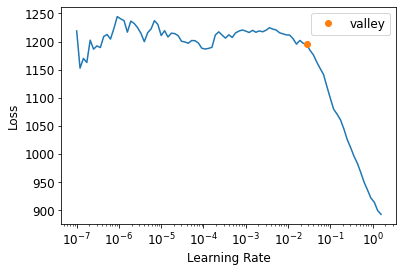

In [ ]:
learn_csv.lr_find()

In [ ]:
learn_csv.fine_tune(epochs=10, base_lr=1.2e-2)

epoch,train_loss,valid_loss,mae,mse,_rmse,time
0,1197.519531,1042.499634,27.274525,1042.499634,32.287762,00:00


epoch,train_loss,valid_loss,mae,mse,_rmse,time
0,1061.733887,986.608398,26.839228,986.608398,31.410322,00:00
1,1005.379883,848.494751,24.604532,848.494751,29.128933,00:00
2,860.999146,498.278687,16.702454,498.278687,22.322155,00:00
3,651.987610,287.892487,11.798390,287.892487,16.967394,00:00
4,493.010742,250.891571,11.698799,250.891571,15.839558,00:00
5,398.944733,253.695328,11.842354,253.695328,15.927816,00:00
6,339.561462,243.616806,11.532000,243.616806,15.608228,00:00
7,300.098999,245.248734,11.547806,245.248734,15.660419,00:00
8,275.579285,242.810806,11.546104,242.810806,15.582387,00:00
9,261.224884,242.386581,11.544865,242.386581,15.568769,00:00


In [ ]:
learn_csv.show_results()

,size,color,bg,day,like,completed,price,price_pred
0,3.0,2.0,1.0,3.072324,-0.413447,-0.627019,36.0,37.904354
1,1.0,2.0,1.0,-0.909650,-0.195475,-0.213427,18.0,13.510807
2,2.0,2.0,1.0,-0.071339,-0.340789,-0.609037,20.0,24.413275
3,4.0,1.0,1.0,-0.280917,-0.340789,-0.483161,25.0,23.158909
4,1.0,2.0,1.0,-0.490495,-0.413447,-0.501144,12.0,16.969086
5,3.0,2.0,2.0,1.814858,0.603757,2.645753,32.0,47.936424
6,2.0,2.0,1.0,-0.490495,-0.413447,-0.591055,10.0,21.789934
7,1.0,2.0,1.0,-0.700072,-0.413447,-0.447197,20.0,15.768592
8,2.0,2.0,1.0,1.814858,-0.340789,-0.519126,18.0,32.638695


# Combine Models

validation set

In [ ]:
df_valid = df[df.dataset=='valid']
predict_price, true_price = [], []

for i, row in df_valid.iterrows():
    valid_img = Path('/content/img/valid/'+row.path)
    valid_csv = df_valid[df_valid.path==row.path].drop(columns=['path', 'dataset']).iloc[0]
    predict_img = float(learn_img.predict(valid_img)[1])
    predict_csv = float(learn_csv.predict(valid_csv)[1])
    predict_price.append((predict_csv+predict_img)/2)
    true_price.append(float(row.price))

mean_absolute_error(predict_price, true_price)

10.357035716655208

test set

In [ ]:
df_test = df[df.dataset=='test']
predict_price, true_price = [], []

for i, row in df_test.iterrows():
    test_img = Path('/content/test/'+row.path)
    test_csv = df_test[df_test.path==row.path].drop(columns=['path', 'dataset']).iloc[0]
    predict_img = float(learn_img.predict(test_img)[1])
    predict_csv = float(learn_csv.predict(test_csv)[1])
    predict_price.append((predict_csv+predict_img)/2)
    true_price.append(float(row.price))

mean_absolute_error(predict_price, true_price)

10.687129513069987

# Other

predict with mean

In [7]:
train_data = df

Y_true = train_data.price
Y_pred = [train_data.price.mean() for i in range(train_data.shape[0])]

train_data.price.mean(), mean_absolute_error(Y_true, Y_pred)

(29.8754191321499, 14.562211815646043)

export models

In [ ]:
learn_img.export('img_reg.pkl')
learn_csv.export('csv_reg.pkl')

In [ ]:
from google.colab import files

files.download('/content/img_reg.pkl')
files.download('/content/csv_reg.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test by downloading the exported models

In [ ]:
learn_inf_img = load_learner('/content/img_reg.pkl')
learn_inf_csv = load_learner('/content/csv_reg.pkl')

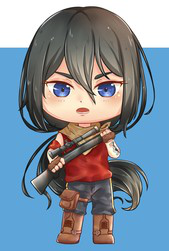

In [ ]:
img = PILImage.create('/content/test/img-1624.jpg')
img

In [ ]:
test = df[df.path=='img-1624.jpg'].drop(columns=['path', 'dataset']).iloc[0]
test

day           5.0
price        10.0
size          1.0
color         1.0
bg            0.0
like          1.0
completed     7.0
Name: 270, dtype: float64

In [ ]:
predict_img = float(learn_inf_img.predict(img)[1])
predict_csv = predict_img if test is None else float(learn_inf_csv.predict(test)[1])
predict_com = (predict_csv+predict_img)/2
predict_com

21.042898178100586